 Тариф «Смарт»
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: минута разговора - 3 рубля, сообщение - 3 рубля, 1 Гб интернет-трафика - 200 рублей


 Тариф «Ультра»
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: минута разговора - 1 рубль, сообщение - 1 рубль, 1 Гб интернет-трафика - 150 рублей

## Шаг 1. Открытие файла и изучение информации

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [24]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [25]:
#name_list = {calls : 'Звонки', internet : 'Интернет', messages : 'Сообщения', tariffs : 'Тарифы', users : 'Пользователи'}

for data in [calls, internet, messages, tariffs, users]: 
    print(data.head(), end='\n\n')
    print(data.info(), end='\n\n')
    print(data.describe(), end='\n\n')
    print('_______________________________________________________________')


       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

            duration        user_id
count  202607.000000  202607.000000
mean        6.755887    1253.940619
std         5.843365     144.722751
min         0.000000    1000.000000
25%         1.300000    1126.000000
50%         6.000000    1260.000000
75%        10.700000    1379.000000
max        38.000000    1499.000000

_______________________________________________________________
   Unnamed: 0      id  mb_used session_dat

В полученных таблицах не наблюдается пропусков. Необходимо заменить у столбцов с датой и временем тип данных. В столбцах с количеством минут - минуты окргуглить до целочисленных значений в большую сторону (по условию). Мегабайты необходимо тоже округлить до целых значений в большую сторону. Разобраться с нулевыми значениями в столбцах с минутами и мегабайтами.
Затем следует оъединить данные (звонки, сообщения, интернет).

Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

## Шаг 2. Предобработка данных

### Приведение данных к нужным типам

Приведем данные с датами к временному типу.

In [26]:
def to_datetime(data, column):
    data[column] = pd.to_datetime(data[column], format='%Y-%m-%d')


In [27]:
to_datetime(calls, 'call_date')
to_datetime(internet, 'session_date')
to_datetime(messages, 'message_date')
to_datetime(users, 'reg_date')
to_datetime(users, 'churn_date')

Округлим данные по минутам и мегабайтам в большую сторону.

In [28]:
#calls['duration'] = calls['duration'].round() -round() без дополнительных настреок 
#округляет до ближайшего числа, отлично подойдет np.ceil
calls['duration'] = calls['duration'].apply(np.ceil)
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

In [29]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

### Ошибки

In [30]:
calls['duration'].value_counts().head(5)

0.0    39613
7.0    11510
6.0    11457
5.0    11411
8.0    11272
Name: duration, dtype: int64

In [31]:
internet['mb_used'].value_counts().head(5)

0.0      19598
333.0      231
382.0      228
377.0      224
253.0      222
Name: mb_used, dtype: int64

Нулевые значения в данных с минутами и инетрнетом составляют околло 21% и 13% соответствено. Необходимо понять как они влияют на статистику данных.

#### Рассмотрим зависимости количества нулей от общего числа звонков за каждый месяц. 
Для этого создадим столбец где нули будут отмечены единицей и преобразуем данные времени по месяцам.

In [32]:
calls.loc[calls['duration'] == 0, 'nulls'] = 1
#df.loc[df['a'] == 0, 'a'] = 1 
#df['a'] = df['a'].fillna(0)

In [33]:
calls['month'] = calls['call_date'].dt.month

In [34]:
calls.head()

,id,call_date,duration,user_id,nulls,month
0,1000_0,2018-07-25,0.0,1000,1.0,7
1,1000_1,2018-08-17,0.0,1000,1.0,8
2,1000_2,2018-06-11,3.0,1000,NaN,6
3,1000_3,2018-09-21,14.0,1000,NaN,9
4,1000_4,2018-12-15,6.0,1000,NaN,12


In [35]:
null_calls = calls.pivot_table(index = 'month', values = ['nulls', 'id'], aggfunc = 'count')
null_calls['null_ratio'] = round(null_calls['nulls'] / null_calls['id'], 2)
null_calls.columns = ['all_calls', 'nulls', 'null_ratio']
null_calls

,all_calls,nulls,null_ratio
month,,,
1,1476,312,0.21
2,3328,623,0.19
3,6687,1304,0.20
4,9272,1768,0.19
5,12647,2531,0.20
6,14716,2883,0.20
7,18298,3518,0.19
8,21488,4231,0.20
9,24061,4615,0.19


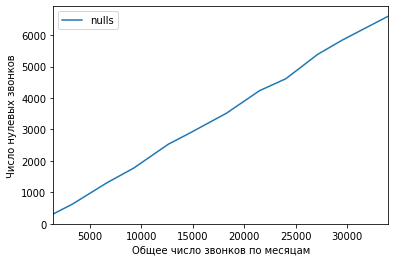

In [36]:
null_calls.plot(x = 'all_calls', y = 'nulls')
plt.xlabel('Общее число звонков по месяцам')
plt.ylabel('Число нулевых звонков');

Видим, что появление нулей систематично. Поэтому заменим их на единицу, будем считать что оператор даже доли секунды считает за звонок.

In [37]:
calls.loc[calls['duration'] == 0, 'duration'] = 1

#### Рассмотрим зависимость количества нулевых значений от общего числа интернет-периодов за каждый месяц. 
Для этого создадим столбец где нули будут отмечены единицей и преобразуем данные времени по месяцам.

In [38]:
internet.loc[internet['mb_used'] == 0, 'nulls'] = 1

In [39]:
internet['month'] = internet['session_date'].dt.month

In [40]:
null_mb = internet.pivot_table(index='month', values=['id', 'nulls'], aggfunc='count')
null_mb['null_ratio'] = round(null_mb['nulls'] / null_mb['id'], 3)
null_mb.columns = ['all', 'nulls', 'null_ratio']
null_mb

,all,nulls,null_ratio
month,,,
1,1117,151,0.135
2,2641,378,0.143
3,4885,623,0.128
4,6511,819,0.126
5,9408,1199,0.127
6,11057,1401,0.127
7,13548,1760,0.130
8,16092,2083,0.129
9,17512,2314,0.132


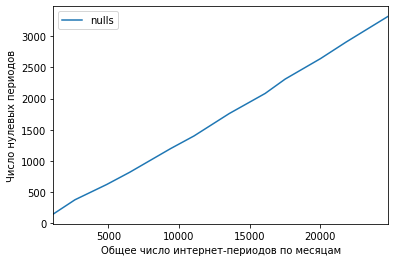

In [41]:
null_mb.plot(x = 'all', y = 'nulls')
plt.xlabel('Общее число интернет-периодов по месяцам')
plt.ylabel('Число нулевых периодов');

Так же как и в случае звонков видим, что появление нулей систематично. Поэтому тоже заменим их на единицы.

In [42]:
internet.loc[internet['mb_used'] == 0, 'mb_used'] = 1

Найдем для каждого пользователя:

количество сделанных звонков и израсходованных минут разговора по месяцам;
количество отправленных сообщений по месяцам;
объем израсходованного интернет-трафика по месяцам.

### Количество сделанных звонков и израсходованных минут разговора по месяцам;

Объединим данные двух таблиц. Получим сводную таблицу по звонкам и минутам.

In [43]:
calls_new = calls.merge(users, on='user_id', how='inner')
calls_new.head()

,id,call_date,duration,user_id,nulls,month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000_0,2018-07-25,1.0,1000,1.0,7,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000_1,2018-08-17,1.0,1000,1.0,8,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000_2,2018-06-11,3.0,1000,NaN,6,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000_3,2018-09-21,14.0,1000,NaN,9,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000_4,2018-12-15,6.0,1000,NaN,12,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [44]:
calls_grouped = calls_new.pivot_table(index=['user_id', 'month'], values=['duration','city'], aggfunc={'duration': 'sum', 'city': 'count'})
calls_grouped.columns = ['calls', 'duration']
calls_grouped

calls  duration
user_id month                 
1000    5         22     164.0
        6         43     187.0
        7         47     346.0
        8         52     418.0
        9         58     478.0
...              ...       ...
1498    10        41     258.0
1499    9          9      71.0
        10        68     473.0
        11        74     624.0
        12        69     505.0

[3174 rows x 2 columns]

### Количество отправленных сообщений по месяцам

Объединим данные двух таблиц. Получим сводную таблицу сообщениям.

In [45]:
messages['month'] = messages['message_date'].dt.month
messages_new = messages.merge(users, on='user_id', how='inner')
messages_new.head()

,id,message_date,user_id,month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000_0,2018-06-27,1000,6,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000_1,2018-10-08,1000,10,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000_2,2018-08-04,1000,8,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000_3,2018-06-16,1000,6,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000_4,2018-12-05,1000,12,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [46]:
messages_grouped = messages_new.pivot_table(index=['user_id', 'month'], values='city', aggfunc='count')
messages_grouped.columns = ['messages']
messages_grouped

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
...                 ...
1498    10           42
1499    9            11
        10           48
        11           59
        12           66

[2717 rows x 1 columns]

### Объем израсходованного интернет-трафика по месяцам

Объединим данные двух таблиц. Получим сводную таблицу по интернет-трафику.

In [47]:
internet_new = internet.merge(users, on='user_id', how='inner')
internet_new.head()

,Unnamed: 0,id,mb_used,session_date,user_id,nulls,month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,0,1000_0,113.0,2018-11-25,1000,NaN,11,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1,1000_1,1053.0,2018-09-07,1000,NaN,9,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,2,1000_2,1198.0,2018-06-25,1000,NaN,6,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,3,1000_3,551.0,2018-08-22,1000,NaN,8,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,4,1000_4,303.0,2018-09-24,1000,NaN,9,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [48]:
internet_grouped = internet_new.pivot_table(index=['user_id', 'month'],values='mb_used',aggfunc='sum')
internet_grouped.columns = ['mb_used']
internet_grouped

mb_used
user_id month         
1000    5       2257.0
        6      23262.0
        7      14017.0
        8      14072.0
        9      14583.0
...                ...
1498    10     20614.0
1499    9       1849.0
        10     17824.0
        11     17994.0
        12     13082.0

[3203 rows x 1 columns]

### Сводная таблица по всем трем полученным таблицам.

In [49]:
df1 = calls_grouped.merge(messages_grouped, on=['user_id', 'month'], how='inner')
df2 = df1.merge(internet_grouped, on=['user_id', 'month'], how='inner')
df2.head()

calls  duration  messages  mb_used
user_id month                                    
1000    5         22     164.0        22   2257.0
        6         43     187.0        60  23262.0
        7         47     346.0        75  14017.0
        8         52     418.0        81  14072.0
        9         58     478.0        57  14583.0

In [50]:
for user in df2.index:
    df2.loc[user, 'tariff'] = users.loc[user[0]- 1000, 'tariff']
df2.head()

calls  duration  messages  mb_used tariff
user_id month                                           
1000    5         22     164.0        22   2257.0  ultra
        6         43     187.0        60  23262.0  ultra
        7         47     346.0        75  14017.0  ultra
        8         52     418.0        81  14072.0  ultra
        9         58     478.0        57  14583.0  ultra

### Помесячная выручка с каждого пользователя

Теперь для каждого пользователя посчитаем помесячную выручку (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [51]:
def det_revenue(row):
    tariff = row['tariff']
    duration = row['duration']
    calls = row['calls']
    messages = row['messages']
    mb_used = row['mb_used']
   
    if tariff == 'smart':
        over_duration = duration - tariffs.loc[0, 'minutes_included']
        over_messages = messages - tariffs.loc[0, 'messages_included']
        over_mb = mb_used - tariffs.loc[0, 'mb_per_month_included']
        
        if over_duration < 0: 
            over_duration = 0
        if over_messages < 0: 
            over_messages = 0
        if over_mb < 0: 
            over_mb = 0
        
        return (over_duration * tariffs.loc[0, 'rub_per_minute'] + 
                over_messages * tariffs.loc[0, 'rub_per_message'] + 
                over_mb * (tariffs.loc[0, 'rub_per_gb'] / 1024) + 
                tariffs.loc[0, 'rub_monthly_fee']) 
    
    if tariff == 'ultra':
        over_duration = duration - tariffs.loc[1, 'minutes_included']
        over_messages = messages - tariffs.loc[1, 'messages_included']
        over_mb = mb_used - tariffs.loc[1, 'mb_per_month_included']
        
        if over_duration < 0: 
            over_duration = 0
        if over_messages < 0: 
            over_messages = 0
        if over_mb < 0: 
            over_mb = 0
        
        return (over_duration * tariffs.loc[1, 'rub_per_minute'] + 
                over_messages * tariffs.loc[1, 'rub_per_message'] + 
                over_mb * (tariffs.loc[1, 'rub_per_gb'] / 1024) + 
                tariffs.loc[1, 'rub_monthly_fee'])

df2['pay'] = df2.apply(det_revenue, axis=1)
df2.head(10)

calls  duration  messages  mb_used tariff          pay
user_id month                                                        
1000    5         22     164.0        22   2257.0  ultra  1950.000000
        6         43     187.0        60  23262.0  ultra  1950.000000
        7         47     346.0        75  14017.0  ultra  1950.000000
        8         52     418.0        81  14072.0  ultra  1950.000000
        9         58     478.0        57  14583.0  ultra  1950.000000
        10        57     363.0        73  14717.0  ultra  1950.000000
        11        43     344.0        58  14769.0  ultra  1950.000000
        12        46     341.0        70   9829.0  ultra  1950.000000
1002    6         15     118.0         4  10878.0  smart   550.000000
        7         26     219.0        11  17615.0  smart   990.429688

## Шаг 3. Анадиз данных

### Посчитаем минуты разговора, количество сообщений и объем интернет-трафика

Посчитаем сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.

In [52]:
mean = df2.pivot_table(index='user_id', values=['duration', 'messages', 'mb_used'], aggfunc='mean')
mean

,duration,mb_used,messages
user_id,,,
1000,330.125000,13438.250000,62.0
1002,223.000000,16607.857143,10.0
1003,782.800000,11466.200000,76.0
1004,128.000000,18649.250000,149.0
1005,564.333333,8320.916667,46.0
...,...,...,...
1495,803.800000,25509.200000,68.0
1496,512.083333,22617.500000,39.0
1497,483.666667,15214.000000,17.0


In [53]:
#for user in mean.index:
 #   mean.loc[user, 'tariff'] = users.loc[user- 1000, 'tariff']
#mean.head()
mean_new = mean.merge(df2['tariff'], on='user_id', how='inner')
mean_new = mean_new.drop_duplicates()
mean_new.head()

,duration,mb_used,messages,tariff
user_id,,,,
1000,330.125000,13438.250000,62.0,ultra
1002,223.000000,16607.857143,10.0,smart
1003,782.800000,11466.200000,76.0,ultra
1004,128.000000,18649.250000,149.0,ultra
1005,564.333333,8320.916667,46.0,smart


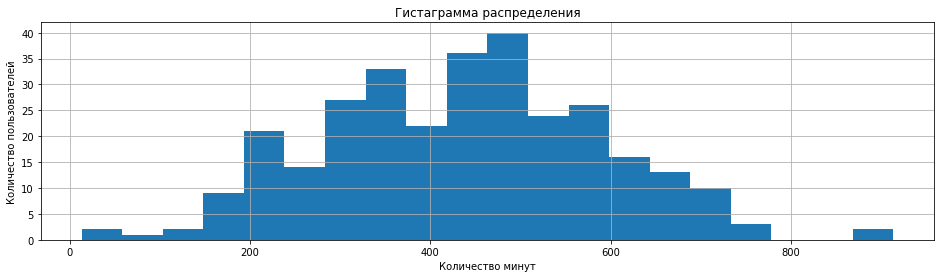

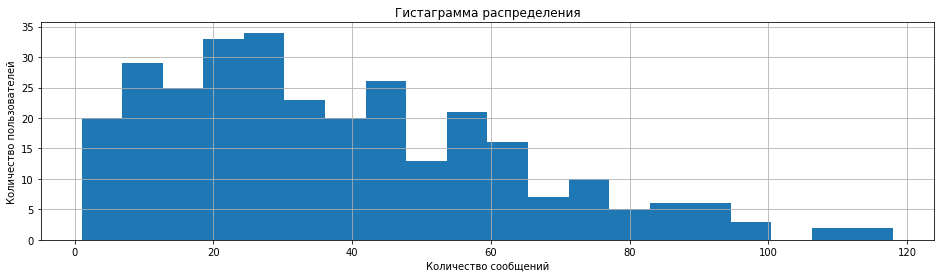

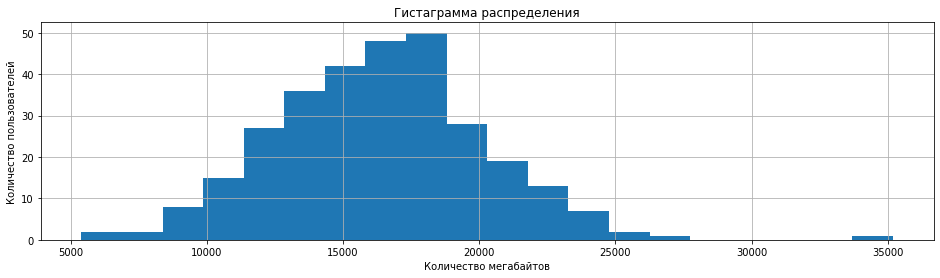

In [54]:
smart = mean_new.query('tariff == "smart"')

column_list = ['duration', 'messages', 'mb_used']
name_list = {'duration':'Количество минут', 'messages':'Количество сообщений', 'mb_used':'Количество мегабайтов'}
for column in column_list:
    #mean_new.plot(y = column, figsize = (16,4));
    smart.hist(column, figsize = (16,4), bins = 20);
    plt.xlabel(name_list[column])
    plt.ylabel('Количество пользователей');
    plt.title('Гистаграмма распределения')
    plt.show()

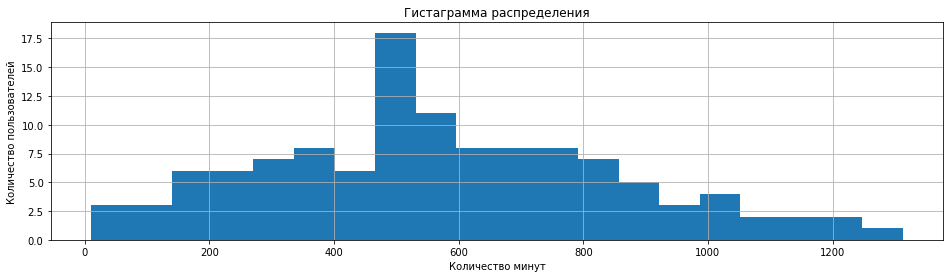

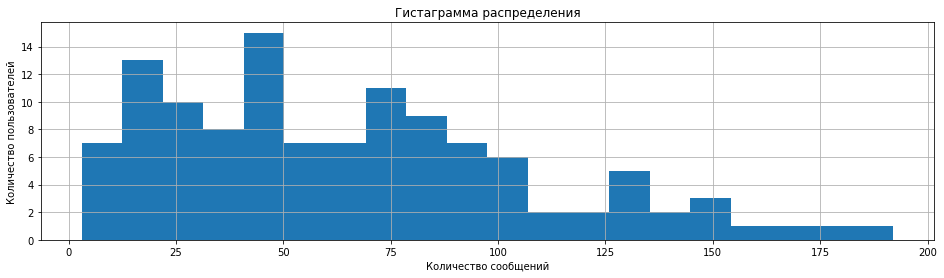

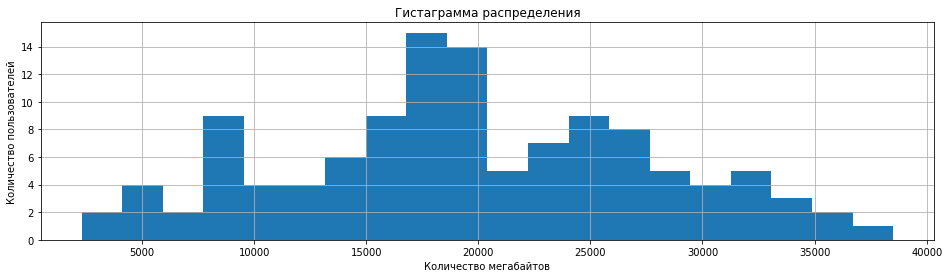

In [55]:
ultra = mean_new.query('tariff == "ultra"')

column_list = ['duration', 'messages', 'mb_used']
name_list = {'duration':'Количество минут', 'messages':'Количество сообщений', 'mb_used':'Количество мегабайтов'}
for column in column_list:
    #ultra.plot(y = column, figsize = (16,4));
    ultra.hist(column, figsize = (16,4), bins = 20);
    plt.xlabel(name_list[column])
    plt.ylabel('Количество пользователей');
    plt.title('Гистаграмма распределения')
    plt.show()

### Cреднее количество, дисперсия и стандартное отклонение

Посчитаем среднее количество, дисперсию и стандартное отклонение по тарифу. 

In [56]:
stat_data = mean_new.pivot_table(index=['tariff'], 
                             values=['duration', 'messages', 'mb_used'],
                             aggfunc={'duration': [np.mean, np.median, np.var, np.std], 
                             'messages': [np.mean, np.median, np.var, np.std],
                             'mb_used': [np.mean, np.median, np.var, np.std]})
stat_data.columns = (['duration_mean', 'duration_med', 'duration_std', 'duration_var',
                      'mb_used_mean', 'mb_used_med', 'mb_used_std', 'mb_used_var',
                      'messages_mean', 'messages_med', 'messages_std', 'messages_var'])
stat_data

,duration_mean,duration_med,duration_std,duration_var,mb_used_mean,mb_used_med,mb_used_std,mb_used_var,messages_mean,messages_med,messages_std,messages_var
tariff,,,,,,,,,,,,
smart,436.609220,447.000,151.965153,23093.407667,16362.866915,16287.8,3867.022036,1.495386e+07,37.640339,33.000000,24.875570,618.793959
ultra,574.159859,545.375,281.845177,79436.704035,19600.060162,18793.5,8084.898326,6.536558e+07,65.418990,59.166667,42.410864,1798.681344


По тарифу Ультра дисперсия по всем показателям больше в отличии от тарифа Смарт. Так же в тарифе Ультра медианы смещены в большую сторону.
Рассмотрим выбросы по тарифам.

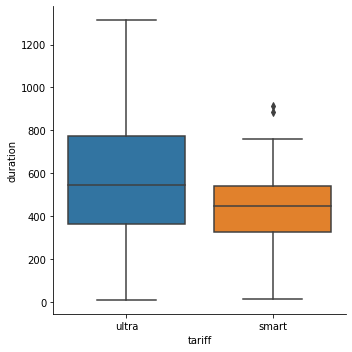

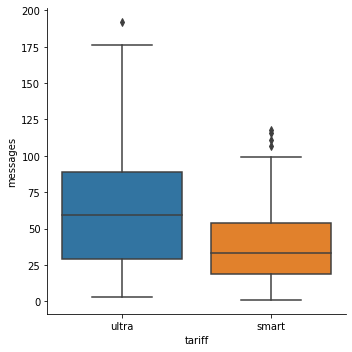

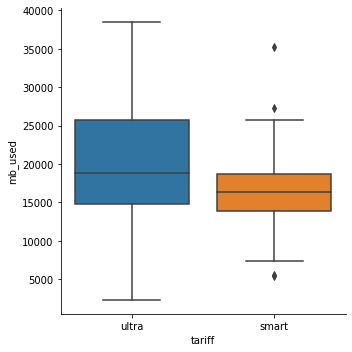

In [57]:
for column in ['duration', 'messages', 'mb_used']:    
    sns.catplot(x="tariff", y=column, kind="box", data=mean_new, orient='v')  

Выбросов тарифе "Смарт", больше чем тарифе "Ультра".

### Построение гистограммы

Смарт - голубой, Ультра - красный.

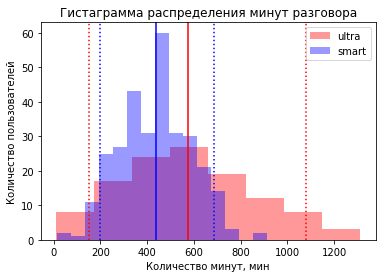

In [60]:
tariff = ['ultra', 'smart']
palette = {'ultra':'red', 'smart':'blue'}
for tariff in tariff:
    sns.distplot(mean_new.query('tariff == @tariff')['duration'], kde=False, label=tariff, color = palette[tariff])
    plt.axvline(mean_new.query('tariff == @tariff')['duration'].mean(), color = palette[tariff])
    plt.axvline(mean_new.query('tariff == @tariff')['duration'].quantile(0.95), 
                linestyle = ':', color = palette[tariff])
    plt.axvline(mean_new.query('tariff == @tariff')['duration'].quantile(0.05), 
                linestyle = ':', color = palette[tariff])
    plt.rcParams['figure.figsize']=(10,10)
    plt.legend()
    plt.xlabel('Количество минут, мин')
    plt.ylabel('Количество пользователей');
    plt.title('Гистаграмма распределения минут разговора')

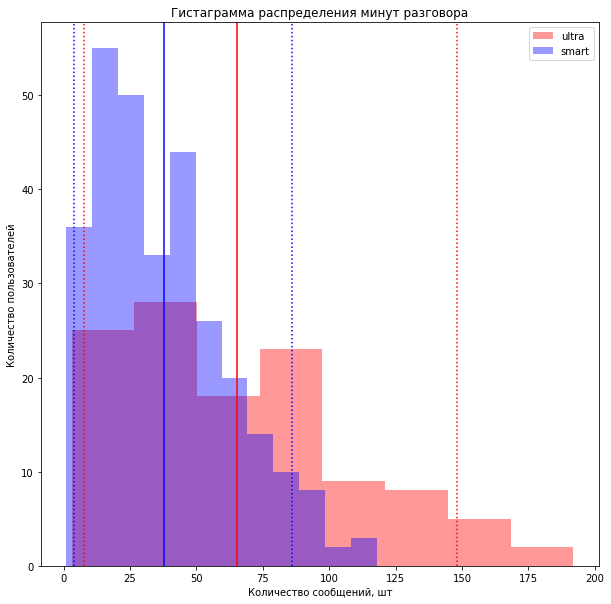

In [61]:
tariff = ['ultra', 'smart']
palette = {'ultra':'red', 'smart':'blue'}
for tariff in tariff:
    sns.distplot(mean_new.query('tariff == @tariff')['messages'], kde=False, label=tariff, color = palette[tariff])
    plt.axvline(mean_new.query('tariff == @tariff')['messages'].mean(), color = palette[tariff])
    plt.axvline(mean_new.query('tariff == @tariff')['messages'].quantile(0.95), 
                linestyle = ':', color = palette[tariff])
    plt.axvline(mean_new.query('tariff == @tariff')['messages'].quantile(0.05), 
                linestyle = ':', color = palette[tariff])
    plt.rcParams['figure.figsize']=(10,10)
    plt.legend()
    plt.xlabel('Количество сообщений, шт')
    plt.ylabel('Количество пользователей');
    plt.title('Гистаграмма распределения минут разговора')

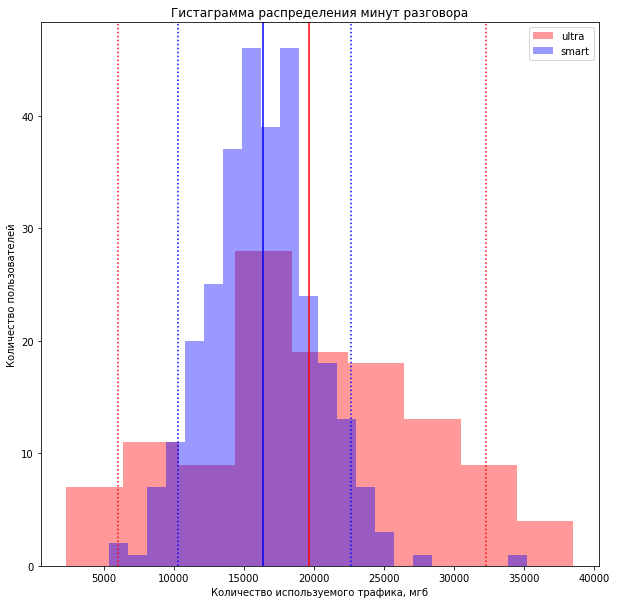

In [62]:
tariff = ['ultra', 'smart']
palette = {'ultra':'red', 'smart':'blue'}
for tariff in tariff:
    sns.distplot(mean_new.query('tariff == @tariff')['mb_used'], kde=False, label=tariff, color = palette[tariff])
    plt.axvline(mean_new.query('tariff == @tariff')['mb_used'].mean(), color = palette[tariff])
    plt.axvline(mean_new.query('tariff == @tariff')['mb_used'].quantile(0.95), 
                linestyle = ':', color = palette[tariff])
    plt.axvline(mean_new.query('tariff == @tariff')['mb_used'].quantile(0.05), 
                linestyle = ':', color = palette[tariff])
    plt.rcParams['figure.figsize']=(10,10) 
    plt.legend()
    plt.xlabel('Количество используемого трафика, мгб')
    plt.ylabel('Количество пользователей');
    plt.title('Гистаграмма распределения минут разговора')


По гистограммам видно, что дисперсия по тарифу "Ультра" действительно больше чем у тарифа "Смарт" по всем показателям. Так же стоит отметить, что мода у тарифа "Смарт" более выражена. Это значит, что пользователи тарифа "Ультра" более свободны в выборе своих операций.

## Шаг 4. Проверка гипотез

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

𝐻0  — средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».

𝐻1  — средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Рассмотрим диспесии

In [63]:
tariff_var = df2.pivot_table(index=['tariff'], values=['pay'], aggfunc=np.var)
tariff_var

,pay
tariff,
smart,643853.795683
ultra,99479.229610


Дисперсии отличаются, значит примем величину equal_var = False

In [64]:
ultra = df2.query('tariff == "ultra"')['pay']
smart = df2.query('tariff == "smart"')['pay']
alpha = .05

results = st.ttest_ind(ultra, smart, equal_var = False)
print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 5.4128612227739204e-236
Отвергаем нулевую гипотезу


In [65]:
df2.pivot_table(index='tariff', values='pay', aggfunc='median')

,pay
tariff,
smart,981.023438
ultra,1950.000000


Исходя из проверки гипотез, видно что с вероятностью 95% доходы с пользователя по по тарифу "Ультра" действительно отличаются по сравнению с доходами от тарифа "Смарт". Средние значения выручки по тарифам отличаются практически в 2 раза (1950 - Ультра, 933 - Смарт). При этом из среднего потарифу Смарт видно, что в среднем пользователи переплачивают из за нехватки услуг в предлагаемом тарифном пакете.

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

𝐻0 — средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

𝐻1 — средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.

In [66]:
for user in df2.index:
    df2.loc[user, 'city'] = users.loc[user[0]-1000 , 'city']
df2.head()

calls  duration  messages  mb_used tariff     pay       city
user_id month                                                              
1000    5         22     164.0        22   2257.0  ultra  1950.0  Краснодар
        6         43     187.0        60  23262.0  ultra  1950.0  Краснодар
        7         47     346.0        75  14017.0  ultra  1950.0  Краснодар
        8         52     418.0        81  14072.0  ultra  1950.0  Краснодар
        9         58     478.0        57  14583.0  ultra  1950.0  Краснодар

Проведем категоризацию столбца city.

In [67]:
def region(row):
    city = row
    if city == 'Москва':
        return 'Москва'
    return 'Регион'
df2['region'] = df2['city'].apply(region)
df2.head()

calls  duration  messages  mb_used tariff     pay       city  \
user_id month                                                                 
1000    5         22     164.0        22   2257.0  ultra  1950.0  Краснодар   
        6         43     187.0        60  23262.0  ultra  1950.0  Краснодар   
        7         47     346.0        75  14017.0  ultra  1950.0  Краснодар   
        8         52     418.0        81  14072.0  ultra  1950.0  Краснодар   
        9         58     478.0        57  14583.0  ultra  1950.0  Краснодар   

               region  
user_id month          
1000    5      Регион  
        6      Регион  
        7      Регион  
        8      Регион  
        9      Регион

Рассмотрим диспесии

In [68]:
region_var = df2.pivot_table(index=['region'], values=['pay'], aggfunc=np.var)
region_var

,pay
region,
Москва,573058.119584
Регион,625298.082038


In [69]:
df2

calls  duration  messages  mb_used tariff          pay  \
user_id month                                                           
1000    5         22     164.0        22   2257.0  ultra  1950.000000   
        6         43     187.0        60  23262.0  ultra  1950.000000   
        7         47     346.0        75  14017.0  ultra  1950.000000   
        8         52     418.0        81  14072.0  ultra  1950.000000   
        9         58     478.0        57  14583.0  ultra  1950.000000   
...              ...       ...       ...      ...    ...          ...   
1498    10        41     258.0        42  20614.0  smart  1576.171875   
1499    9          9      71.0        11   1849.0  smart   550.000000   
        10        68     473.0        48  17824.0  smart  1031.250000   
        11        74     624.0        59  17994.0  smart  1463.453125   
        12        69     505.0        66  13082.0  smart   613.000000   

                      city  region  
user_id month                       
1000    5        Краснодар  Регион  
        6        Краснодар  Регион  
        7        Краснодар  Регион  
        8        Краснодар  Регион  
        9        Краснодар  Регион  
...                    ...     ...  
1498    10     Владикавказ  Регион  
1499    9            Пермь  Регион  
        10           Пермь  Регион  
        11           Пермь  Регион  
        12           Пермь  Регион  

[2667 rows x 8 columns]

Дисперсии можно считать равными, поэтому примем величину equal_var = True

In [70]:
mockow = df2.query('region == "Москва"')['pay']
region = df2.query('region == "Регион"')['pay']
alpha = .05

results = st.ttest_ind(mockow, region, equal_var = True)
print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.10099437590522067
Не получилось отвергнуть нулевую гипотезу


In [71]:
df2.pivot_table(index = 'region', values = 'pay', aggfunc = 'median')

,pay
region,
Москва,1778.710938
Регион,1463.011719


Исходя из проверки гипотезы ясно что с вероятностью 95% средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов. И действительно из расчета среднего видим что среднее прибыли особо не отличается.
Построим диаграммы размаха для наглядности.

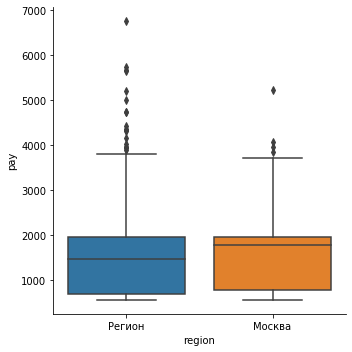

In [72]:
sns.catplot(x="region", y='pay', kind="box", data=df2, orient='v');

## Шаг 5. Общий вывод

В ходе работы нам необходимо было сравнить два тарифных плана: «Смарт» и «Ультра» для корректировки рекламного бюджета. для этого необходимо понять какой тариф приносит больше денег. Изначально были просмотрены данные и выполнена их предобработка. Была произведена работа с нулевыми значениями в данных с минутами и мегабайтами. Затем был сделан предварительный анализ тарифов на предоставленной выборке клиентов из 500 пользователей. Для этого была сформированна таблица пользователей, где для каждого было указано количество сделанных звонков, израсходованных минут, отправленных сообщений и объем израсходованного интернет-трафика по месяцам и вычислена помесячная выручка за месяц. В ходе ииследования полученных данных в таблице было выявлено:
* средние значения выручки тарифа "Ультра" практически в 2 раза больше (1950 руб - "Ультра", 981 руб - "Смарт")
* пользователям тарифа "Смарт" не хватает условий пакета, в среднем переплата составляет 431 руб ежемесячно - около 78%
* пользователи тарифа "Ультра" не используют все условия пакета
* средние доходы от пользователей по Москве и регионам особо не отличаются, разница статистически не значительная и составляет около 316 рублей (1779 руб - Москва, 1463 руб - регионы)

Так же в ходе анализа данных были посчитанны среднее количество, дисперсия и стандартное отклонение по тарифу и построенны гистограммы распределения минут разговора, сообщений и объема используемого интернет-трафика. По полученным гистаграммам было обнаружено, что дисперсия по тарифу "Ультра" действительно больше чем у тарифа "Смарт" по всем показателям. Так же было выявлено, что мода у тарифа "Смарт" более выражена. Это значит, что пользователи тарифа "Ультра" более свободны в выборе своих операций.